In [1]:
%run PLT.py
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
# import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [4]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run decomposition.py
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


# Get Data

In [80]:
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])


## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [81]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

 # Weather
 
 ## GB --> Hydrocat 720
 

In [7]:
MetData = PLT.get_buoy('2021-11-01', '2023-07-01','GB','MetData')

In [82]:
df = pd.DataFrame (MetData) 

In [83]:
for i in df.keys():
    if i == 'TmStamp':
        df[i] = pd.to_datetime(df[i])

In [84]:
df = df.drop(['DateTime','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity', 'avgWindDir', 'gustWindDir'], axis=1)
df = df.rename(columns = {'TmStamp': 'DateTime'})

In [85]:
hydrocat720['DateTime'] = hydrocat720['DateTime'].dt.tz_localize('UTC')

In [86]:
hydrocat720 = pd.merge_asof(hydrocat720, df, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat720 = hydrocat720.reset_index(drop=True)
hydrocat720

,DateTime,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),avgWindSpeed,gustWindSpeed,maximetTemperature,maximetPrecipitation
0,2022-01-02 05:46:15.400000+00:00,7.3282,29.8873,9.294,8.041448,21.481,8.041448,7.915810,2.61694,3.27244,9.1,0.08
1,2022-01-03 00:16:15.600000+00:00,7.1784,29.5282,9.521,8.061112,21.745,8.061112,7.932631,6.62453,9.47942,2.8,0.00
2,2022-01-03 00:31:15.400000+00:00,7.0309,29.1730,9.687,8.080780,23.895,8.080780,7.949489,7.97240,9.97034,2.6,0.00
3,2022-01-03 01:16:15.400000+00:00,7.0331,29.2548,9.922,8.100912,21.341,8.100912,7.969298,8.28121,10.66050,2.2,0.00
4,2022-01-03 02:01:15.400000+00:00,7.0196,29.3446,9.844,8.111086,21.587,8.111086,7.979060,6.88892,8.93238,1.8,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
36668,2023-06-09 22:46:28.800000+00:00,16.1736,29.5935,7.014,7.784883,0.011,7.784883,7.802567,3.26661,4.13958,14.0,0.08
36669,2023-06-09 23:01:28.800000+00:00,16.2630,29.5499,7.333,7.814661,0.012,7.814661,7.833828,2.56963,3.47752,13.6,0.00
36670,2023-06-09 23:16:28.800000+00:00,16.3589,29.5593,7.554,7.834495,0.012,7.834495,7.855207,1.86252,2.88637,13.6,0.00
36671,2023-06-09 23:31:28.800000+00:00,16.3755,29.5284,7.689,7.854425,0.011,7.854425,7.875481,3.04814,4.28986,14.0,0.00


### add change in pH to `hydrocat720` (which now includes weather data)


In [87]:
hydrocat720['dpH'] = hydrocat720['pH final'].diff()
hydrocat720_rain = hydrocat720.where(hydrocat720['maximetPrecipitation']>=hydrocat720['maximetPrecipitation'].quantile(0.99)).dropna()


In [88]:
hydrocat720_rain = hydrocat720_rain.reset_index(drop=True)

In [89]:
hydrocat720_rain

,DateTime,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),avgWindSpeed,gustWindSpeed,maximetTemperature,maximetPrecipitation,dpH
0,2022-02-18 05:01:26.400000+00:00,3.9969,22.9905,11.343,8.265939,47.234,8.265939,8.079121,14.77910,22.0147,13.1,8.16,-0.021772
1,2022-02-22 18:01:30+00:00,4.0489,18.0643,12.376,8.269132,40.148,8.269132,8.083551,10.24790,12.7202,8.2,7.20,-0.009907
2,2022-02-22 19:01:15.400000+00:00,3.9165,19.7127,11.975,8.251437,39.493,8.251437,8.063812,9.24752,11.0675,7.4,10.56,-0.017695
3,2022-02-22 22:46:13+00:00,4.0552,21.1760,11.400,8.163234,28.211,8.163234,7.980027,10.85020,13.5205,8.4,10.32,-0.088203
4,2022-04-07 21:01:15.200000+00:00,8.0913,27.3707,10.114,8.196061,2.637,8.196061,8.081320,11.06760,13.8104,8.4,6.88,0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2023-06-04 23:16:28.800000+00:00,16.3095,28.1798,6.377,7.802861,0.010,7.802861,7.822620,8.42890,12.1723,11.0,7.04,-0.000195
363,2023-06-04 23:31:28.800000+00:00,16.2991,28.2401,6.295,7.792954,0.010,7.792954,7.812509,8.09804,10.0109,11.3,8.80,-0.009907
364,2023-06-04 23:46:28.800000+00:00,16.0214,28.3955,6.642,7.803646,0.011,7.803646,7.819083,7.88786,11.5300,11.4,8.56,0.010693
365,2023-06-05 00:01:47.800000+00:00,15.9951,28.5480,6.589,7.813885,0.010,7.813885,7.828968,8.51948,11.0555,11.4,8.40,0.010238


In [90]:
temp = {'DateTime': [], 'pH': [], 'dpH': []}
# RAIN is a dataset with datetimes and ph changes of rain events
# when there is available data 24 hours after
RAIN = hydrocat720_rain
for i in hydrocat720_rain.index:
    # Get datetime of rain
    ds = hydrocat720_rain['DateTime'][i]
    # Find where in original dataset 24 hours after is
    dd = hydrocat720.where(hydrocat720['DateTime'] == (ds + timedelta(hours = 24))).dropna()
    # If a measurement 24 hr after rain exists
    if dd.size > 0:
        # put it in temp data
        temp['DateTime'].append(dd['DateTime'].values[0])
        temp['pH'].append(dd['pH final'].values[0])
        temp['dpH'].append(dd['dpH'].values[0])
    else:
        # drops rain events that do not have data 24 hours after
        RAIN = RAIN.drop(i)

In [91]:
_24hr_after = pd.DataFrame(temp)

_24hr_after = _24hr_after.reset_index(drop=True)
RAIN = RAIN.reset_index(drop=True)

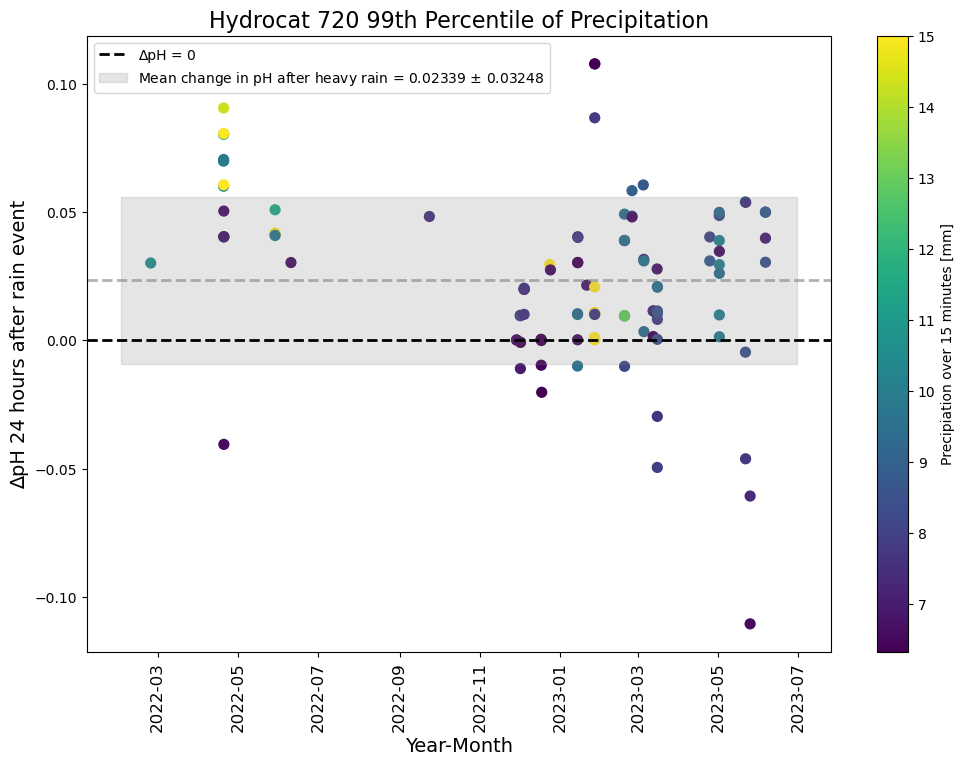

In [96]:
fig, ax = plt.subplots(figsize = [12,8])
y = _24hr_after['dpH']
y = RAIN['pH final'] - _24hr_after['pH']
x = _24hr_after['DateTime']
im = ax.scatter(x,y, c = RAIN['maximetPrecipitation'], vmax = 15, s = 50)
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Precipiation over 15 minutes [mm]')
mn = np.mean(y)
st = np.std(y, ddof = 1)
MN = "%.5f" % mn
ST = "%.5f" % st
ax.axhline(y=np.mean(y), color='gray', linestyle='dashed', lw = 2, alpha = 0.6)

ax.axhline(y=0, color='black', linestyle='dashed', lw = 2, 
           label = '∆pH = 0')

ax.fill_between([datetime(2022, 2, 1), datetime(2023, 6, 30)], mn - st, mn + st, color = 'gray', alpha = 0.2,
               label = 'Mean change in pH after heavy rain = ' + MN + ' $\pm$ ' + ST)

ax.set_ylabel('∆pH 24 hours after rain event', fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.set_xlabel('Year-Month', fontsize = 14)
ax.set_title('Hydrocat 720 99th Percentile of Precipitation', fontsize = 16)
ax.legend()
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/H720_24hr_afterrain.png', bbox_inches='tight')

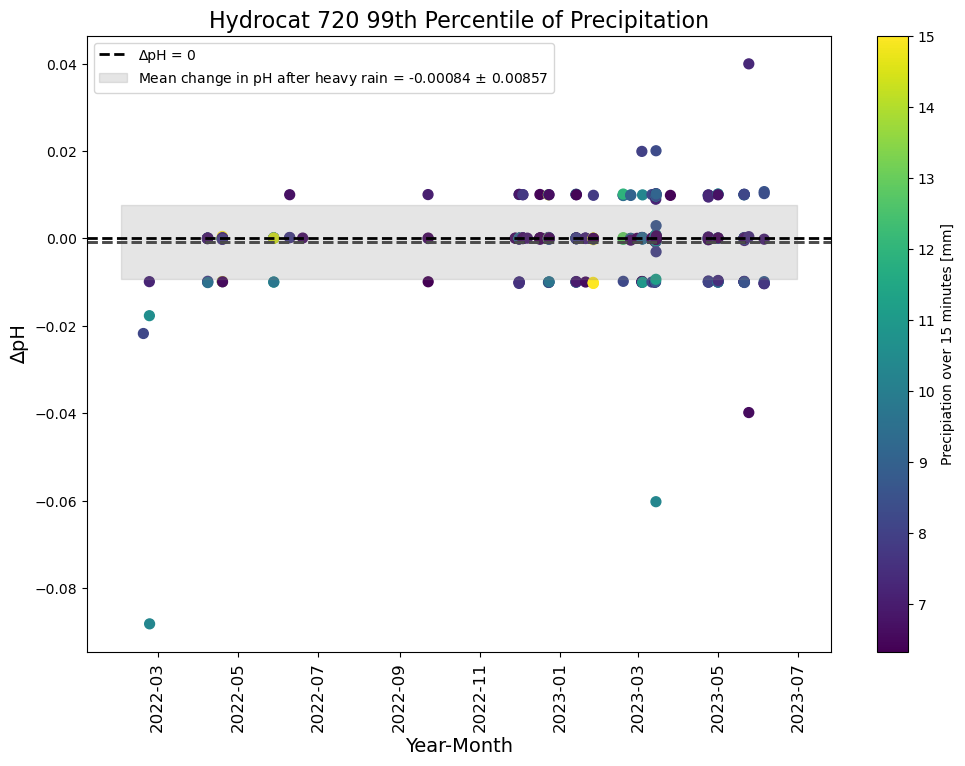

In [97]:
fig, ax = plt.subplots(figsize = [12,8])
y = hydrocat720_rain['dpH']
x = hydrocat720_rain['DateTime']
im = ax.scatter(x,y, c = hydrocat720_rain['maximetPrecipitation'], vmax = 15, s = 50)
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Precipiation over 15 minutes [mm]')
mn = np.mean(y)
st = np.std(y, ddof = 1)
MN = "%.5f" % mn
ST = "%.5f" % st
ax.axhline(y=np.mean(y), color='k', linestyle='dashed', lw = 2)

ax.axhline(y=np.mean(y), color='gray', linestyle='dashed', lw = 2, alpha = 0.6)

ax.axhline(y=0, color='black', linestyle='dashed', lw = 2, 
           label = '∆pH = 0')

ax.fill_between([datetime(2022, 2, 1), datetime(2023, 6, 30)], mn - st, mn + st, color = 'gray', alpha = 0.2,
               label = 'Mean change in pH after heavy rain = ' + MN + ' $\pm$ ' + ST)

ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.set_xlabel('Year-Month', fontsize = 14)
ax.set_title('Hydrocat 720 99th Percentile of Precipitation', fontsize = 16)
ax.legend()
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/H720_fromrain.png', bbox_inches='tight')

In [53]:
purple = '#6a4c93'
blue = '#1982c4'
green = '#8ac926'
yellow = '#ffca3a'
red = '#FF595E'

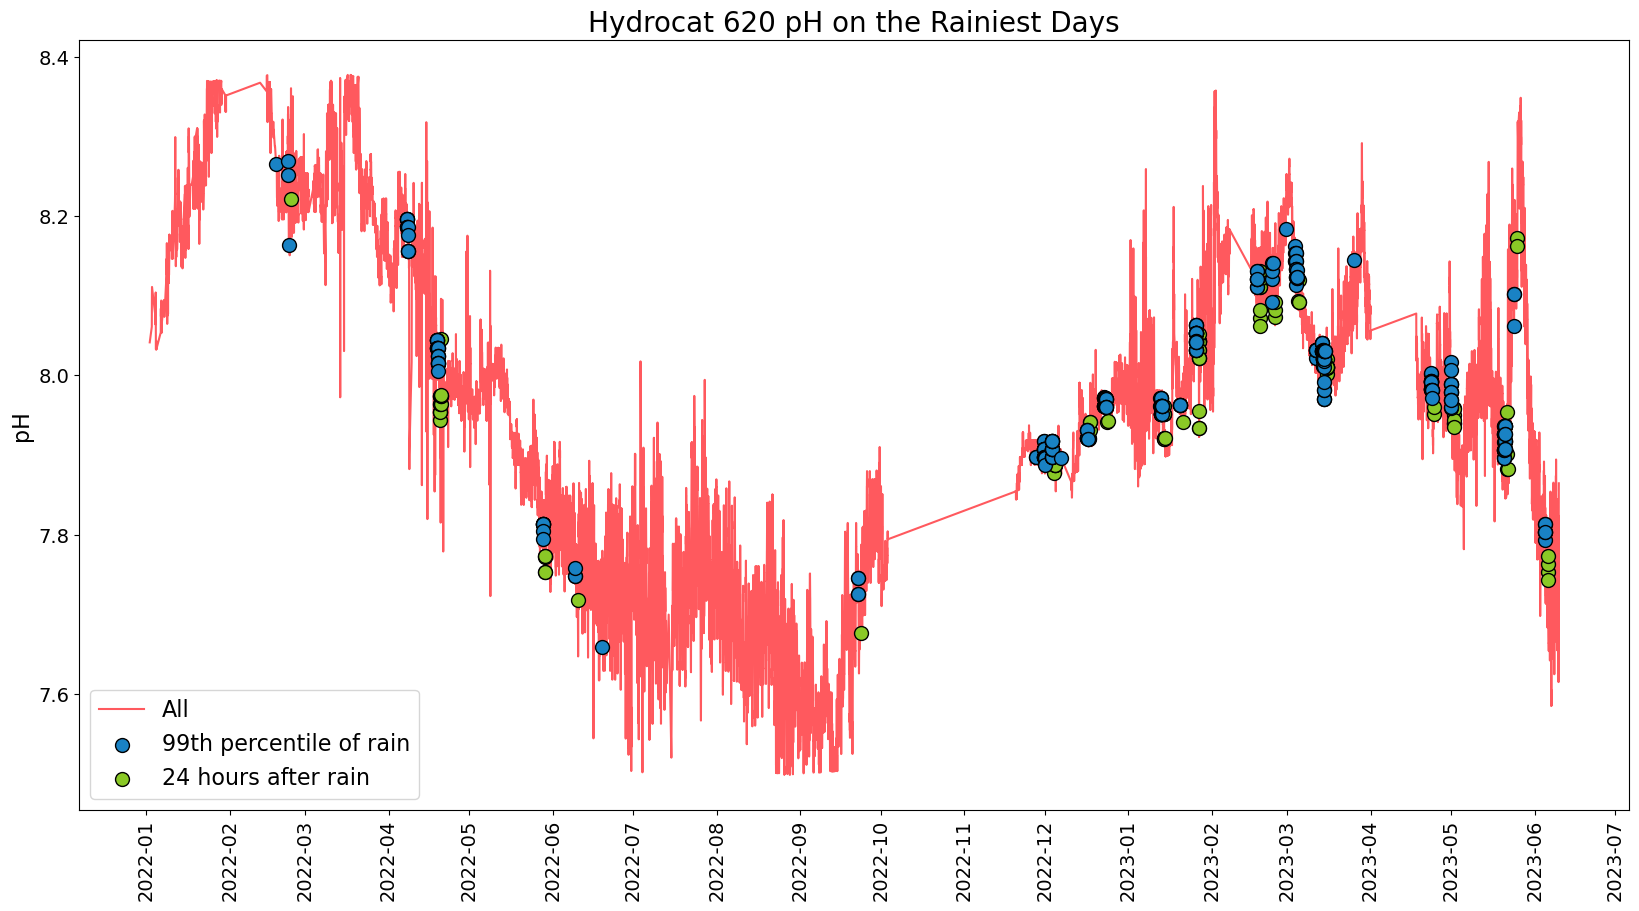

In [98]:
fig, ax = plt.subplots(figsize = [20,10])
ax.plot(hydrocat720['DateTime'], hydrocat720['pH final'], label = 'All', color = red)
ax.scatter(hydrocat720_rain['DateTime'], hydrocat720_rain['pH final'], s = 100, edgecolors = 'k',
           facecolors = blue, zorder = 3, label = '99th percentile of rain')
ax.scatter(_24hr_after['DateTime'], _24hr_after['pH'], s = 100, edgecolors = 'k',
           facecolors = green, zorder = 2, label = '24 hours after rain')
ax.legend(fontsize = 16)
ax.set_ylabel('pH', fontsize = 16)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 14, labelrotation = 90)
ax.tick_params('y',labelsize = 14)
ax.set_title('Hydrocat 620 pH on the Rainiest Days', fontsize = 20)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/H720_rain.png', bbox_inches='tight')

# ax2 = ax.twinx()
# # ax2.scatter(met['DateTime'].where(met['maximetPrecipitation'] > 0), met['maximetPrecipitation'].where(met['maximetPrecipitation'] > 0), color = 'green', label = 'All')
# ax2.scatter(met2['DateTime'], met2['maximetPrecipitation'], color = 'cyan', label = 'All')
# ax2.set_ylabel('Precip')


## PLT --> Hydrocat 620

In [63]:
MetData_PLT = PLT.get_buoy('2021-11-01', '2023-07-01','PLT','MetData')

In [99]:
df = pd.DataFrame (MetData_PLT)

for i in df.keys():
    if i == 'TmStamp':
        df[i] = pd.to_datetime(df[i])
        
df = df.drop(['DateTime','metdataStart', 'maximetSolar', 'maximetPressure', 'maximetHumidity', 'avgWindDir', 'gustWindDir'], axis=1)
df = df.rename(columns = {'TmStamp': 'DateTime'})

In [123]:
hydrocat620['DateTime'] = hydrocat620['DateTime'].dt.tz_localize('UTC')

In [124]:
hydrocat620 = pd.merge_asof(hydrocat620, df, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()
hydrocat620 = hydrocat620.reset_index(drop=True)

hydrocat620['dpH'] = hydrocat620['pH final'].diff()
hydrocat620_rain = hydrocat620.where(hydrocat620['maximetPrecipitation']>=hydrocat620['maximetPrecipitation'].quantile(0.99)).dropna()
hydrocat620_rain = hydrocat620_rain.reset_index(drop=True)

In [126]:
temp = {'DateTime': [], 'pH': [], 'dpH': []}
# RAIN is a dataset with datetimes and ph changes of rain events
# when there is available data 24 hours after
RAIN = hydrocat620_rain
for i in hydrocat620_rain.index:
    # Get datetime of rain
    ds = hydrocat620_rain['DateTime'][i]
    # Find where in original dataset 24 hours after is
    dd = hydrocat620.where(hydrocat620['DateTime'] == (ds + timedelta(hours = 48))).dropna()
    # If a measurement 24 hr after rain exists
    if dd.size > 0:
        # put it in temp data
        temp['DateTime'].append(dd['DateTime'].values[0])
        temp['pH'].append(dd['pH final'].values[0])
        temp['dpH'].append(dd['dpH'].values[0])
    else:
        # drops rain events that do not have data 24 hours after
        RAIN = RAIN.drop(i)

In [128]:
_24hr_after = pd.DataFrame(temp)

_24hr_after = _24hr_after.reset_index(drop=True)
RAIN = RAIN.reset_index(drop=True)

In [129]:
RAIN['pH final'] - _24hr_after['pH']

0     0.059571
1     0.076867
2     0.067025
3     0.030590
4     0.030504
        ...   
91    0.010742
92    0.000785
93    0.000933
94    0.032644
95    0.002856
Length: 96, dtype: float64

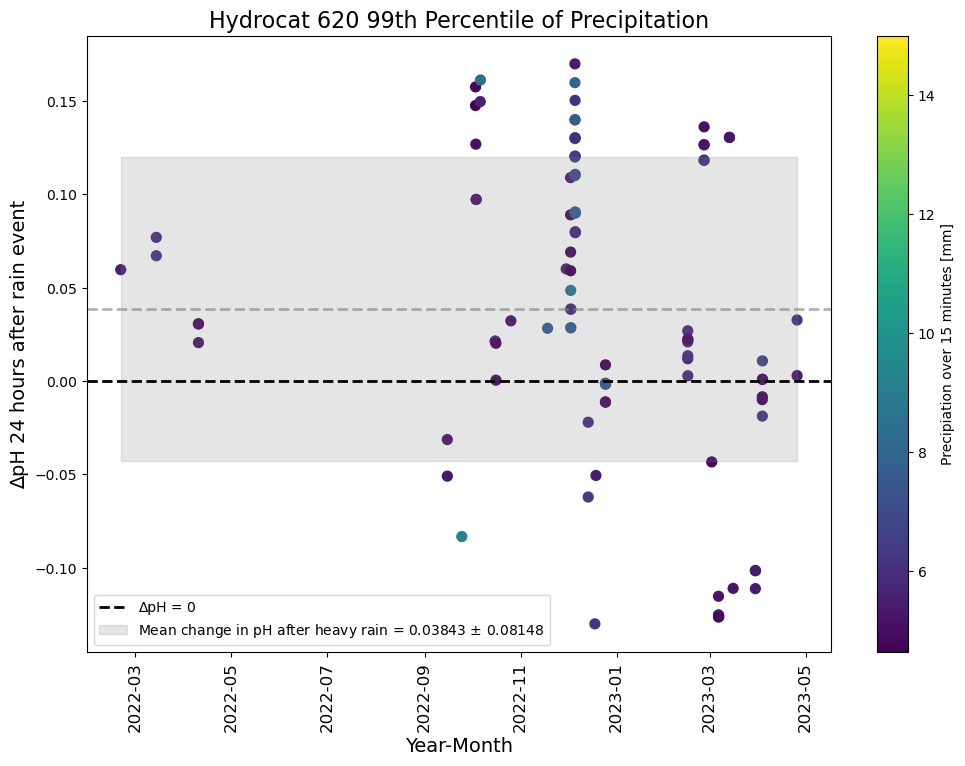

In [130]:
fig, ax = plt.subplots(figsize = [12,8])
y = _24hr_after['dpH']
y = RAIN['pH final'] - _24hr_after['pH']
x = _24hr_after['DateTime']
im = ax.scatter(x,y, c = RAIN['maximetPrecipitation'], vmax = 15, s = 50)
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Precipiation over 15 minutes [mm]')
mn = np.mean(y)
st = np.std(y, ddof = 1)
MN = "%.5f" % mn
ST = "%.5f" % st
ax.axhline(y=np.mean(y), color='gray', linestyle='dashed', lw = 2, alpha = 0.6)

ax.axhline(y=0, color='black', linestyle='dashed', lw = 2, 
           label = '∆pH = 0')

ax.fill_between(x, mn - st, mn + st, color = 'gray', alpha = 0.2,
               label = 'Mean change in pH after heavy rain = ' + MN + ' $\pm$ ' + ST)

ax.set_ylabel('∆pH 24 hours after rain event', fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.set_xlabel('Year-Month', fontsize = 14)
ax.set_title('Hydrocat 620 99th Percentile of Precipitation', fontsize = 16)
ax.legend()
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/H620_24hr_afterrain.png', bbox_inches='tight')

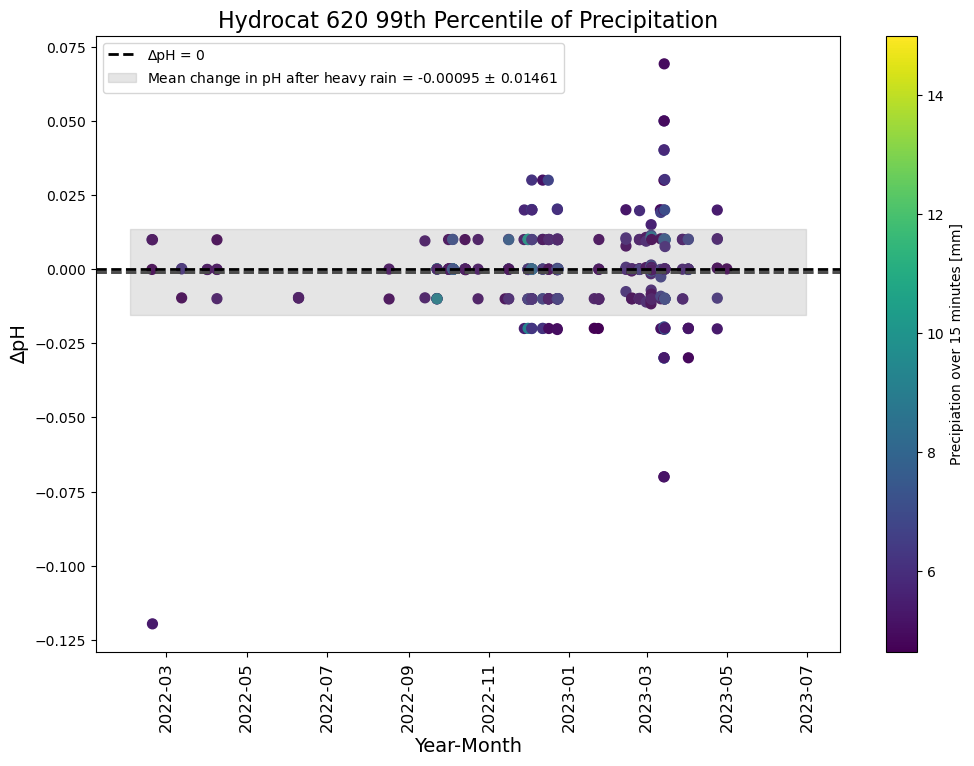

In [131]:
fig, ax = plt.subplots(figsize = [12,8])
y = hydrocat620_rain['dpH']
x = hydrocat620_rain['DateTime']
im = ax.scatter(x,y, c = hydrocat620_rain['maximetPrecipitation'], vmax = 15, s = 50)
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Precipiation over 15 minutes [mm]')
mn = np.mean(y)
st = np.std(y, ddof = 1)
MN = "%.5f" % mn
ST = "%.5f" % st
ax.axhline(y=np.mean(y), color='k', linestyle='dashed', lw = 2)

ax.axhline(y=np.mean(y), color='gray', linestyle='dashed', lw = 2, alpha = 0.6)

ax.axhline(y=0, color='black', linestyle='dashed', lw = 2, 
           label = '∆pH = 0')

ax.fill_between([datetime(2022, 2, 1), datetime(2023, 6, 30)], mn - st, mn + st, color = 'gray', alpha = 0.2,
               label = 'Mean change in pH after heavy rain = ' + MN + ' $\pm$ ' + ST)

ax.set_ylabel('∆pH', fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)
ax.set_xlabel('Year-Month', fontsize = 14)
ax.set_title('Hydrocat 620 99th Percentile of Precipitation', fontsize = 16)
ax.legend()
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/H620_fromrain.png', bbox_inches='tight')

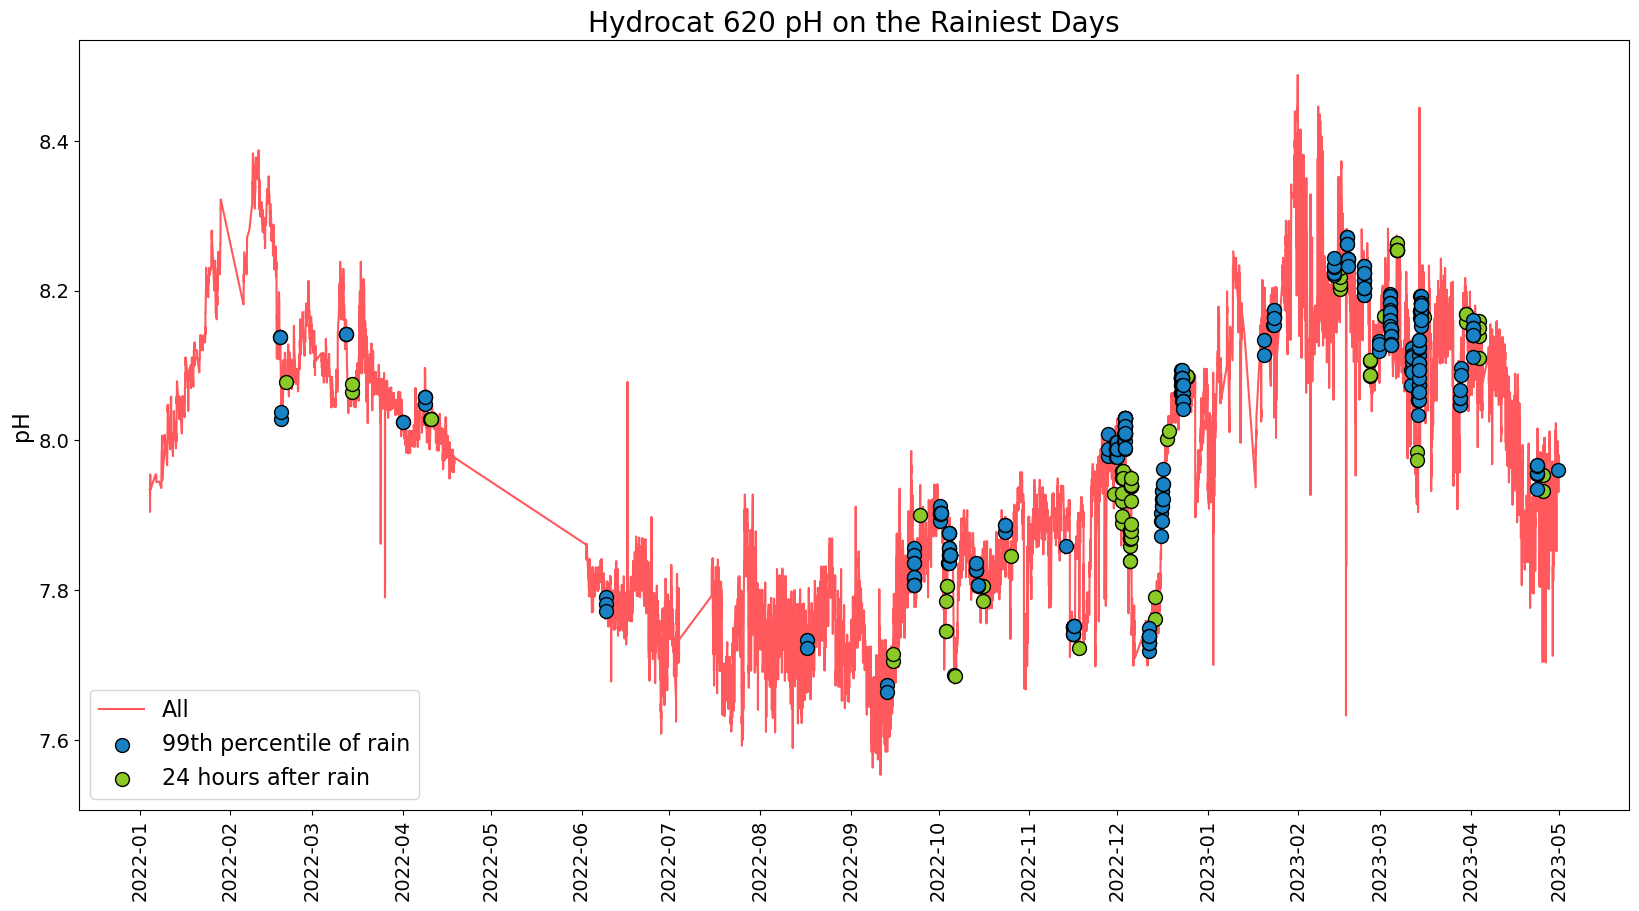

In [132]:
fig, ax = plt.subplots(figsize = [20,10])
ax.plot(hydrocat620['DateTime'], hydrocat620['pH final'], label = 'All', color = red)
ax.scatter(hydrocat620_rain['DateTime'], hydrocat620_rain['pH final'], s = 100, edgecolors = 'k',
           facecolors = blue, zorder = 3, label = '99th percentile of rain')
ax.scatter(_24hr_after['DateTime'], _24hr_after['pH'], s = 100, edgecolors = 'k',
           facecolors = green, zorder = 2, label = '24 hours after rain')
ax.legend(fontsize = 16)
ax.set_ylabel('pH', fontsize = 16)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 14, labelrotation = 90)
ax.tick_params('y',labelsize = 14)
ax.set_title('Hydrocat 620 pH on the Rainiest Days', fontsize = 20)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/phyto/H620_rain.png', bbox_inches='tight')

# ax2 = ax.twinx()
# # ax2.scatter(met['DateTime'].where(met['maximetPrecipitation'] > 0), met['maximetPrecipitation'].where(met['maximetPrecipitation'] > 0), color = 'green', label = 'All')
# ax2.scatter(met2['DateTime'], met2['maximetPrecipitation'], color = 'cyan', label = 'All')
# ax2.set_ylabel('Precip')
